# Chong Jen Darren Ng (47170917) - Assignment 2

In [1]:
import pandas as pd
import re

In [2]:
Data_File = pd.read_csv("A2_Data.csv")

In [3]:
Data_File_2 = Data_File.drop(['Unnamed: 0' , 'Patient_ID', 'Patient_Cause_Of_Pain','Patient_Illness_History', 'Patient_Allergies', 
               'Patient_Family_History', 'Discharge_Condition', 'Discharge_Instructions'], axis=1)
Data_File_2 = Data_File_2.drop_duplicates()

In [4]:
Data_File_2 = Data_File_2.dropna()

In [5]:
Data_File_2 = Data_File_2.reset_index(drop=True)

In [7]:
Data_File_2['Discharge_Decision'].value_counts()

Discharge_Decision
Home                 25842
Home With Service    11453
Extended Care         9791
Expired               1603
Name: count, dtype: int64

# Text Preparation

In this cell, in no more than 150 words, you can elaborate on the the innovativeness and depth of your work on text preparation.

For text preparation, I determine the columns required, then chained assignments are disabled to remove errors and I removed punctuations and numbers to reduce redundancy.
After which tokenization is applied to split larger body of text into smaller lines and all text is converted into lower case for simplicity's sake.
Next I included 4 additional stopwords: 2 english, 1 english with numbers and 1 medical
- Included more english stopwords to remove more redundant or duplicated words
- Included with numbers as there are a lot of numbers in the clinician dataset
- Included medical stopwords to remove any redundant medical terms or words.

Lemmatization is to normalize words and to reduce them to a common base form. It is chosen over stemming as results is more accurate.
TextBlob is included as well as it has built-in sentiment analysis and text correction which is useful for further analysis after Text Preparation

In [9]:
Data_TP = Data_File_2[["Clinician_Note"]]

<b>Removing punctuation, Tokenizing, Converting to lower case</b>

In [10]:
# To remove errors
pd.options.mode.chained_assignment = None 

# Removing punctuations and numbers - reduce redundancy
Data_TP['Clinician_Note'].replace({r'[^\w\s]+': ''}, regex=True, inplace =True)
Data_TP['Clinician_Note'] = Data_TP['Clinician_Note'].str.replace(r'_', '')

# Applying tokenizing
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
Data_TP_Token = Data_TP['Clinician_Note'].apply(word_tokenize)

# Converting text to lower case
Data_TP_Token = Data_TP_Token.apply(lambda x: [word.lower() for word in x])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\winTen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<b>Removing stopwords using NLTK and external packages</b>

In [11]:
# NLTK english basic stopwords - tutorial
from nltk.corpus import stopwords
nltk.download('stopwords')
My_SW = stopwords.words("English")
Data_TP_Stop = Data_TP_Token.apply(lambda x: [word for word in x if word not in My_SW])  



# 3 english and 1 medical stopwords are added
import requests
url = "https://raw.githubusercontent.com/igorbrigadir/stopwords/master/en/atire_puurula.txt"
response = requests.get(url)
data = response.text
Data_TP_Stop1 = Data_TP_Stop.apply(lambda x: [word for word in x if word not in data])  

url = "https://raw.githubusercontent.com/igorbrigadir/stopwords/master/en/tonybsk_6.txt"
response = requests.get(url)
data = response.text
Data_TP_Stop2 = Data_TP_Stop1.apply(lambda x: [word for word in x if word not in data])

url = "https://raw.githubusercontent.com/igorbrigadir/stopwords/master/en/taporware.txt"
response = requests.get(url)
data = response.text
Data_TP_Stop3 = Data_TP_Stop2.apply(lambda x: [word for word in x if word not in data]) 

url = "https://raw.githubusercontent.com/socd06/medical-nlp/master/data/vocab.txt"
response = requests.get(url)
data = response.text
Data_TP_Stop4 = Data_TP_Stop3.apply(lambda x: [word for word in x if word not in data]) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\winTen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<b>Lemmatization</b>

In [13]:
# WordNetLemmatizer added
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
Data_Lem1 = Data_TP_Stop4.apply(lambda x:[lemma.lemmatize(word) for word in x])

In [48]:
# After WordNetLemmatizer lemmatization with TextBlob
from textblob import TextBlob
from textblob import Word

sentence = Data_Lem1.apply(lambda x: (' '.join(x)))
lemmatize_text = lambda text: " ".join([word.lemmatize() for word in TextBlob(text).words])
Data_Lem2 = sentence.apply(lemmatize_text)

# Text feature generation

In this cell, in no more than 150 words, you can elaborate on the the innovativeness of your work on feature generation.

Firstly, enriching data is done to enhance the existing data to provide more context. After which, TF-IDF is done to quantify the significance of a term in relation to the entire corpus which will be implemented during topic modelling.

A total of 4 SVDs (3 SVDs produces almost similar accuracy) are used as there is an improvement in accuracy of at least 3% (49.6% to 52.2%) .
Next, sentiment analysis is done to find polarity to get a better understanding of the dataset.

A bar graph is plotted to show a graphic representation of the dataset in the form of 'Neutral', 'Negative' and 'Positive' polarization.
'Positive' polarization is the highest in this case, which means majority of the text portion falls under the positive sentiment category.

<b>Feature 1 generation (SVD)</b>

<b>Enriching Data</b>

In [15]:
Data_File_Rich = Data_Lem2
Data_File_Enrich = Data_File_2
Data_File_Enrich["Processed_CNote"] = Data_File_Rich
Data_File_Enrich = Data_File_Enrich.drop('Clinician_Note', axis=1)

<b>TF-IDF</b>

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
My_VT = TfidfVectorizer ()
TFIDF = My_VT.fit_transform(Data_File_Enrich["Processed_CNote"])

<b>SVD</b>

In [18]:
from sklearn.decomposition import TruncatedSVD
My_SVD = TruncatedSVD(n_components=4, n_iter=100)
SVD_Trun= My_SVD.fit_transform(TFIDF)
Data_File_Enrich[['SVD1','SVD2', 'SVD3', 'SVD4']] = SVD_Trun

In [20]:
# Check if adding SVD increase accuracy
Data_File_Practice = Data_File_Enrich.drop(columns = ["Processed_CNote"])

nom_column = Data_File_Practice.select_dtypes(include= ['object']) 
num_column = Data_File_Practice.select_dtypes(exclude= ['object']) 

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

nom_convert = nom_column.apply(le.fit_transform)

Data_File_Practice2 = pd.concat([num_column, nom_convert], axis=1)

In [22]:
# Before adding SVD
from sklearn.neural_network import MLPClassifier
My_ANN = MLPClassifier(hidden_layer_sizes=(25,), max_iter=500)
y = Data_File_Practice2 ["Discharge_Decision"]
X = Data_File_Practice2 [['AHRQ Elixhauser score', 'Van Walraven Elixhauser score', 'Gender', 'Service', 'Primary_ICD_Code']]
from sklearn.model_selection import cross_val_score
scores = cross_val_score(My_ANN, X, y, cv=5)
scores.mean()

0.4967661512567968

In [23]:
# After adding SVD there is an increase in accuracy
y = Data_File_Practice2 ["Discharge_Decision"]
X = Data_File_Practice2 [["SVD1", "SVD2", "SVD3", "SVD4",'AHRQ Elixhauser score', 'Van Walraven Elixhauser score', 
                       'Gender', 'Service', 'Primary_ICD_Code']]
from sklearn.model_selection import cross_val_score
scores = cross_val_score(My_ANN, X, y, cv=5)
scores.mean()

0.5222135593928916

<b>Feature 2 generation (Sentiment)</b>

# Sentiment Analysis

In [24]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
My_SA = SentimentIntensityAnalyzer()
sentimental_text_list = []

for sentence in Data_File_Enrich ["Processed_CNote"]:
    text_score = My_SA.polarity_scores(sentence)['compound']
    sentimental_text_list.append(text_score)

polarity_value_list = []
for x in sentimental_text_list:
    if x == 0.0:
        y = "Neutral"
    elif x > 0.0: 
        y = "Positive"
    else: 
        y = "Negative"
    polarity_value_list.append(y)
Data_File_Polar = pd.DataFrame({'Polarity Score':sentimental_text_list ,'Polarity': polarity_value_list})

Text(0.5, 1.0, 'Score')

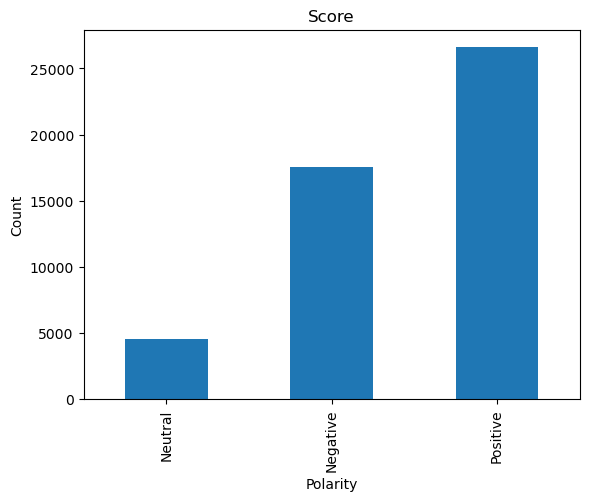

In [51]:
import matplotlib.pyplot as plt
z = Data_File_Polar['Polarity'].value_counts(ascending=True)
bar = z.plot(kind='bar')
bar.set_ylabel("Count")
bar.set_xlabel("Polarity")
bar.set_title("Score")



There is an overall positivity in the given dataset

# Topic modeling & profiling

In this cell, in no more than 300 words, elaborate on the the developed topics and the stories observed in their profiles.

From the PyLDAvis model, the 3 topics displayed are clearly unrelated and distinct from each other. For the first topic, the word "started" gives the highest frequency. For the second topic, most words have similar frequency and for the third topic, it has the lowest frequency and of the lowest significance.

The threshold was set at 0.7, as anything below than this figure provide repetitive word frequency giving contrasting results from the polarity score. The marginal distribution for each of the 3 topics are 2%, 5% and 10%.

The maximum words was chosen to be 35 as anything more than that repetitve words starts to form for each topic which does not give a diverse analysis of the dataset and anything lower than 35, some important words are being removed that affects analysis.

For the first word cloud, "routinely", "tolerating", "ambulating" just to name a few appear as the common words. Based on the dataset, patients tend to be in a serious condition and taking longer than usual to recover from their illness or injury, suggesting negative polarity.

For the second word cloud, "initially" and "started" are the biggest word that appears. Based on the dataset, doctors tend to expect the worst possible outcome. However, patients tend to recover faster than expected, suggesting positive polarity.

Lastly, for the third word cloud, all the words are small in size and randomized, which poses no correlation and of low significance, suggesting neutral polarity.

In [49]:
Data_File_Mod = Data_Lem2.apply(word_tokenize)

In [29]:
import gensim.corpora as corpora

# Create Dictionary and store it to a list 
My_id2word = corpora.Dictionary(Data_File_Mod)

# Store to a list
My_Corpus = [My_id2word.doc2bow(text) for text in Data_File_Mod]

# Build LDA model
from gensim import models

number_of_topics = 3 
My_LDA = models.LdaMulticore(corpus=My_Corpus, id2word=My_id2word, num_topics=number_of_topics)

# Print topics and keywords
My_LDA.print_topics()

C:\Users\winTen\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[(0,
  '0.020*"remained" + 0.018*"admitted" + 0.017*"transferred" + 0.017*"started" + 0.016*"tolerated" + 0.015*"patient" + 0.015*"tolerating" + 0.014*"followup" + 0.013*"underwent" + 0.012*"monitored"'),
 (1,
  '0.020*"started" + 0.008*"patient" + 0.008*"followup" + 0.008*"baseline" + 0.008*"initially" + 0.007*"pcp" + 0.007*"metoprolol" + 0.006*"medication" + 0.006*"consistent" + 0.006*"lasix"'),
 (2,
  '0.023*"medication" + 0.021*"patient" + 0.011*"started" + 0.011*"initially" + 0.008*"admitted" + 0.008*"followup" + 0.008*"transferred" + 0.008*"antibiotic" + 0.007*"discussion" + 0.007*"evaluated"')]

# Topic Vectors

In [30]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import os
number_of_topics = 3
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(number_of_topics))

gensimvis.prepare(My_LDA, My_Corpus, My_id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.048198  0.055807       1        1  49.453075
0     -0.090454  0.002499       2        1  27.997429
2      0.042256 -0.058306       3        1  22.549495, topic_info=           Term          Freq         Total Category  logprob  loglift
169  tolerating  12167.000000  12167.000000  Default  30.0000  30.0000
44   medication  28534.000000  28534.000000  Default  29.0000  29.0000
30     remained  22980.000000  22980.000000  Default  28.0000  28.0000
442   tolerated  17912.000000  17912.000000  Default  27.0000  27.0000
29      patient  34286.000000  34286.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
193     ongoing   2211.118588   7500.893601   Topic3  -5.5788   0.2679
8     worsening   2367.798361  10354.820413   Topic3  -5.5103   0.0140
125  consistent   2441.959251  12668.945996   Topic3  -5.4795  -0.1569
312         qhs   1960.289096   4960.869278   Topic3  -5.6992   0.5610
341   developed   2006.004894   7643.142897   Topic3  -5.6761   0.1518

[294 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
53         1  0.780631     10mg
53         2  0.093592     10mg
53         3  0.125871     10mg
91118      1  0.970959    16027
90832      1  0.971570    17291
...      ...       ...      ...
36247      3  0.977689  wronged
83036      3  0.928018    xyrem
2553       1  0.969584        â
2553       2  0.012928        â
2553       3  0.012928        â

[600 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [31]:
# Grouping the data into 3 topics
topic_probabilities = My_LDA.get_document_topics(bow=My_Corpus)

overall_topic_vectors = []
for element in topic_probabilities:
    document_topic_vector = [0] *number_of_topics
    for TOUPLE in element:
        document_topic_vector[TOUPLE[0]] = TOUPLE[1]   
    overall_topic_vectors.append(document_topic_vector)
    
Data_File_Topic = pd.DataFrame()
Data_File_Topic["Processed CNote"] = Data_File_Rich
Data_File_Topic["Tokens"] = Data_File_Mod
Data_File_Topic[["Topic1", "Topic2", "Topic3"]]= overall_topic_vectors

most_probable_topic_list = []
probability_minimum = 0.7 #threshold decided

for i in overall_topic_vectors:
    
    current_best_probs = [] 
    
    for j in i:
           
        if j >= probability_minimum:
                current_best_probs.append(j)
            
    if len(current_best_probs) > 0: 
        
            most_probable_topic_list.append(i.index(max(current_best_probs)))
    
    else:
            most_probable_topic_list.append(-1)
        
        
Data_File_Topic["Topic_No"]=most_probable_topic_list
Data_File_Topic_NA = Data_File_Topic[Data_File_Topic["Topic_No"] == -1]
Data_File_Topic_0 = Data_File_Topic[Data_File_Topic["Topic_No"] == 0]
Data_File_Topic_1 = Data_File_Topic[Data_File_Topic["Topic_No"] == 1]
Data_File_Topic_2 = Data_File_Topic[Data_File_Topic["Topic_No"] == 2]

# Topic 1 Profile

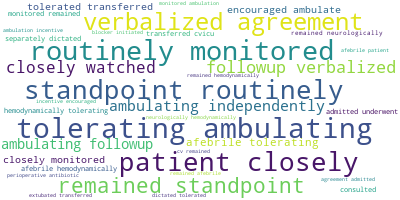

In [32]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from wordcloud import WordCloud
My_WC = WordCloud(background_color="white", max_words=35)

My_LS =','.join(list(Data_File_Topic_0["Processed CNote"].values))
My_WC.generate(My_LS)
My_WC.to_image()

# Topic 2 Profile

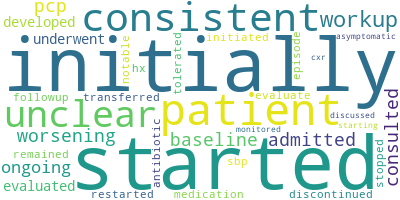

In [33]:
My_LS =','.join(list(Data_File_Topic_1["Processed CNote"].values))
My_WC.generate(My_LS)
My_WC.to_image()

# Topic 3 Profile

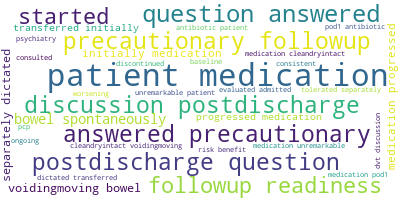

In [34]:
My_LS =','.join(list(Data_File_Topic_2["Processed CNote"].values))
My_WC.generate(My_LS)
My_WC.to_image()

# Model building & evaluation

In this cell, in no more than 150 words, you can elaborate on performance of the developed models.

Firstly text features is added to the dataset including SVD and LDA. After which, Decision Tree model is chosen as preferred choice as it is simpler and more interpretable.

A total of 6 columns are included to test if accuracy improves: 
- AHRQ Elixhauser score
- Van Walraven Elixhauser score
- Gender
- Service
- Primary_ICD_Code
- Discharge_Decision

After which the 3 Topic Models and Polarity Score is chosen for evaluation, which are then test before and after text features are implemented with a default maximum depth of 3. There was an increase in accuracy after implementing text features (56.6% to 57.4%).

Lastly, Gridsearch was executed to determine the ideal maximum depth (max depth: 9), which increases the accuracy even further to 62%. Overall, I'm satisfied with the new accuracy level.

In [52]:
# Dataset before implementing generated text features
Data_File_Before = Data_File_Practice2 [['AHRQ Elixhauser score', 'Van Walraven Elixhauser score', 'Gender', 'Service', 'Primary_ICD_Code', 'Discharge_Decision']]

# Select feature matrix and target vector for both
y_Bef = Data_File_Before["Discharge_Decision"]
X_Bef = Data_File_Before.drop(columns=['Discharge_Decision'])

# Dataset after implementing generated text features (SVD & LDA)
Data_File_Eval = Data_File_Practice2
Data_File_Eval[["Topic1", "Topic2", "Topic3"]]= overall_topic_vectors
Data_File_Eval["Polarity Score"] = Data_File_Polar['Polarity Score']

y_eval = Data_File_Eval["Discharge_Decision"]
X_eval = Data_File_Eval.drop(columns=['Discharge_Decision'])

In [45]:
# Decision tree before text features
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Default parameters for decision tree to have maximum depth of 3 
clf = DecisionTreeClassifier (max_depth = 3) 
clf.fit(X_Bef, y_Bef)
scores = cross_val_score(clf, X_Bef, y_Bef, cv=6, scoring='accuracy')
print("Before Text Features Accuracy:", scores.mean())

Before Text Features Accuracy: 0.5664113098148061


In [46]:
# Decision tree after text features
clf.fit(X_eval, y_eval)
scores = cross_val_score(clf, X_eval, y_eval, cv=6, scoring='accuracy')
print("After Text Features Accuracy:", scores.mean())

After Text Features Accuracy: 0.5740722988642082


In [41]:
# Gridsearch to find ideal maximum depth
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': range(1, 10)}
tree = DecisionTreeClassifier()
model_dt = GridSearchCV(tree, param_grid=param_grid, cv=10, scoring='accuracy')
model_dt.fit(X_eval, y_eval)
model_dt.best_params_

{'max_depth': 9}

In [47]:
clf = DecisionTreeClassifier (max_depth = 9) 
clf.fit(X_eval, y_eval)
scores = cross_val_score(clf, X_eval, y_eval, cv=6, scoring='accuracy')
print("After Gridsearch Accuracy:", scores.mean())

After Gridsearch Accuracy: 0.6197500467384746
